In [1]:
import torch   
precision = 'fp32'
# 从Torch Hub上加载基于COCO dataset 预训练的 SSD模型
ssd_model = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_ssd', model_math=precision)  

import numpy
import scipy
import skimage 
import matplotlib as mt
from skimage import io,transform

utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_ssd_processing_utils')

ssd_model.to('cuda')
ssd_model.eval()

!pip install torchsummary 

Downloading: "https://github.com/NVIDIA/DeepLearningExamples/archive/torchhub.zip" to /root/.cache/torch/hub/torchhub.zip
Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


In [2]:
import os
# 加载图片
# 用于便利地、全面地格式化模型的输入和输出
folder = "/content/drive/My Drive/test_image/"
list_of_test_data = [f for f in os.listdir(folder) if f.endswith('.jpg')]
inputs = [utils.prepare_input(folder+image_path) for image_path in list_of_test_data]
tensor = utils.prepare_tensor(inputs, precision == 'fp16')

# 运行 SDD网络进行目标检测
with torch.no_grad():
    detections_batch = ssd_model(tensor)

# 默认情况下，SSD网络每个输入图像的原始输出包含8732个本地化和类概率分布的盒子。
# 对这个输出进行过滤，以更全面的格式只得到合理的检测结果(置信值>40%)。
results_per_input = utils.decode_results(detections_batch)
best_results_per_input = [utils.pick_best(results, 0.40) for results in results_per_input]

#在COCO dataset上训练模型时，我们需要访问该数据集，以便将类id转换为对象名
# 通过此方法会下载一个包含分类名的txt文件
classes_to_labels = utils.get_coco_object_dictionary()

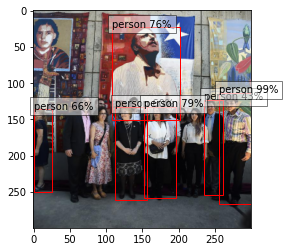

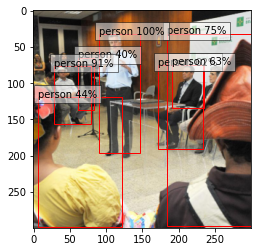

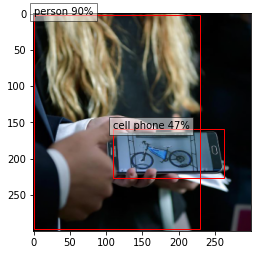

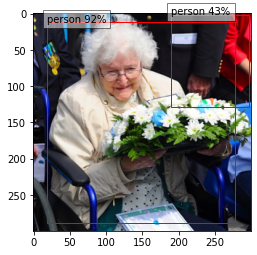

In [3]:
# 可视化结果
from matplotlib import pyplot as plt
import matplotlib.patches as patches

for image_idx in range(len(best_results_per_input)):
    fig, ax = plt.subplots(1)
    # 显示原始的、非规范化的图像
    image = inputs[image_idx] / 2 + 0.5
    ax.imshow(image)
    # 经过检测后
    bboxes, classes, confidences = best_results_per_input[image_idx]
    for idx in range(len(bboxes)):
        left, bot, right, top = bboxes[idx]
        x, y, w, h = [val * 300 for val in [left, bot, right - left, top - bot]]
        rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.text(x, y, "{} {:.0f}%".format(classes_to_labels[classes[idx] - 1], confidences[idx]*100), bbox=dict(facecolor='white', alpha=0.5))
plt.show()